In [1]:
import numpy as np
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import estimator as est
rng = np.random.default_rng(seed=315)
import os
from forestflow.model_p3d_arinyo import ArinyoModel
from forestflow.archive import GadgetArchive3D
from lace.cosmo import camb_cosmo
from forestflow import pcross
from scipy.interpolate import interp1d

Load the data

In [2]:
# set sim_name
sim_name='sim_pair_30' # other version will be 'diffSeed'
sim_dir='central'
snap_num = 4
# set phase
phase = "sim_minus"
# set axis number
axis = 1

In [6]:
# load the skewers
meas_path = "/Users/mlokken/research/lyman_alpha/data/"
delta_x = np.load(meas_path+"snap_{:d}/delta_x/skewers_4_psim_minus_ax1_Ns768_wM0.05_sT1.0_sg1.0.npz".format(snap_num))
delta_flux_x = delta_x['delta_flux_x'] # these are already normalized
Np = delta_flux_x.shape[1]
L = delta_x['L_Mpc']
pix_spacing = L/Np
print("pixel spacing is", pix_spacing, "Mpc")
# xpar = delta_x['xpar'] # this is still wrong for some reason, redefined below
delta_x.close()
xpar = np.arange(0, L, pix_spacing)+pix_spacing/2.

pixel spacing is 0.05 Mpc


In [7]:
Np = delta_flux_x.shape[1]
nskew = delta_flux_x.shape[0]
nside = np.sqrt(nskew).astype(int)
print(f"Box is {L} Mpc per side with {nside} skewers per side")
print(f"Spacing between pixels along line-of-sight = {pix_spacing} Mpc")

# bin delta_flux along line-of-sight
binsize = 10
if Np%binsize != 0:
    print("Np is not divisible by binsize")
    sys.exit()
delta_flux_b, xpar_b = est.bin_spectra(delta_flux_x, xpar, binsize)
Np_b=delta_flux_b.shape[1]
pix_spacing_b = xpar_b[1]-xpar_b[0]
print(f"Spacing between pixels along line-of-sight after binning = {pix_spacing_b} Mpc")

# get the positions
xpos = np.linspace(0,L,nside)
ypos = np.linspace(0,L,nside)
print("spacing between neighboring skewers is {:.2f} Mpc".format(xpos[1]-xpos[0]))
positions = np.array([[x,y] for x in xpos for y in ypos])
subsel=True
nsub=50
if subsel:
    randoms = rng.choice(len(positions), size=nsub)
    sel = np.zeros(len(positions), dtype=bool)
    sel[randoms] = True
else:
    sel = np.ones(len(positions), dtype=bool)
positions_sel = np.copy(positions)
positions_sel[~sel] = np.nan
delta_flux_x[~sel] = np.nan
delta_flux_b[~sel] = np.nan

# reshape into a grid
delta_flux_x = np.reshape(delta_flux_x, (int(nside), int(nside), Np))
delta_flux_b = np.reshape(delta_flux_b, (int(nside), int(nside), Np_b))
position_grid = np.reshape(positions_sel, (int(nside), int(nside), 2))

Box is 67.5 Mpc per side with 768 skewers per side
Spacing between pixels along line-of-sight = 0.05 Mpc
Number of bins: 135
Spacing between pixels along line-of-sight after binning = 0.49999999999999994 Mpc
spacing between neighboring skewers is 0.09 Mpc


In [8]:
delta_x_matrix_binned = est.make_delta_x_matrix(L, Np_b, xpar_b)

Load the model

In [9]:
# get the model

path_program = "/Users/mlokken/research/lyman_alpha/software/ForestFlow/"

folder_lya_data = path_program + "data/best_arinyo/"

Archive3D = GadgetArchive3D(
    base_folder=path_program[:-1],
    folder_data=folder_lya_data,
    force_recompute_plin=False,
    average="both",
)


In [10]:
# read the model
central = Archive3D.get_testing_data("mpg_central")
zs = np.array([central[snap_num]['z']]) 

k3d_Mpc = central[snap_num]['k3d_Mpc']
mu3d = central[snap_num]['mu3d']
p3d_Mpc = central[snap_num]['p3d_Mpc']
Plin = central[snap_num]['Plin']

k1d_Mpc = central[snap_num]['k_Mpc']
p1d_Mpc = central[snap_num]['p1d_Mpc']

arinyo_params = central[snap_num]['Arinyo'] # best-fitting Arinyo params
cosmo_params  = central[snap_num]['cosmo_params']

print(zs)

[3.5]


In [11]:
# input the details into the ArinyoModel class
cosmo = camb_cosmo.get_cosmology_from_dictionary(cosmo_params)
camb_results = camb_cosmo.get_camb_results(cosmo, zs=zs, camb_kmax_Mpc=1000)
arinyo = ArinyoModel(cosmo=cosmo, camb_results=camb_results, zs=zs, camb_kmax_Mpc=1000)
p1d = arinyo.P1D_Mpc(zs[0], np.linspace(0,10,20), parameters=arinyo_params) # get P1D at target z

In [12]:
# Get the weighting matrix
Leff=1000
Np_fine=40000
xfine=np.linspace(0.0,Leff,Np_fine)
spacing_fine=Leff/Np_fine
kfine = np.fft.rfftfreq(Np_fine, spacing_fine)*2*np.pi
p1d_fine = arinyo.P1D_Mpc(zs[0], kfine, parameters=arinyo_params)
xi_fid = np.fft.irfft(p1d_fine) / spacing_fine # to cancel the Mpc.
xi_fid_func = interp1d(xfine, xi_fid, kind='slinear', fill_value='extrapolate')
C0_mat_b = est.c0(xi_fid_func, delta_x_matrix_binned)
C0_invmat_b = np.linalg.inv(C0_mat_b)
# get the fiducial signal
S_fiducial_b = est.s_fid(arinyo, zs[0], arinyo_params, delta_x_matrix_binned, pix_spacing_b)

In [14]:
kpar_b = np.fft.rfftfreq(Np_b, pix_spacing_b)*2*np.pi # frequency in Mpc^-1
kmax = np.pi/pix_spacing_b
kbin_spacing = kpar_b[1]-kpar_b[0]

# make a set of bins with kpar_b as centers
kbin_est = np.array([[kp-(kpar_b[1]-kpar_b[0])/2, kp+(kpar_b[1]-kpar_b[0])/2] for kp in kpar_b])
Nbin = len(kbin_est)

Run the estimator without approximations

In [15]:
kbin_centers, theta_est, F_alpha_beta, Lalpha, times = est.estimate_p1d(Np_b, delta_x_matrix_binned, pix_spacing_b, delta_flux_b, kbin_est, S_fiducial_b, C0_invmat_b, approx_fisher=False, return_times=True)

Starting P1D.
center of kbins:  [0.0, 0.09308422677303092, 0.18616845354606185, 0.2792526803190928, 0.3723369070921237, 0.4654211338651546, 0.5585053606381856, 0.6515895874112164, 0.7446738141842474, 0.8377580409572783, 0.9308422677303092, 1.0239264945033402, 1.1170107212763711, 1.2100949480494019, 1.3031791748224328, 1.3962634015954638, 1.4893476283684948, 1.5824318551415255, 1.6755160819145567, 1.7686003086875874, 1.8616845354606184, 1.9547687622336496, 2.0478529890066803, 2.140937215779711, 2.2340214425527423, 2.327105669325773, 2.4201898960988038, 2.513274122871835, 2.6063583496448657, 2.699442576417897, 2.7925268031909276, 2.8856110299639584, 2.9786952567369895, 3.0717794835100207, 3.164863710283051, 3.257947937056082, 3.3510321638291134, 3.444116390602144, 3.537200617375175, 3.6302848441482056, 3.723369070921237, 3.816453297694268, 3.9095375244672987, 4.00262175124033, 4.095705978013361, 4.188790204786391, 4.281874431559422, 4.374958658332454, 4.4680428851054845, 4.56112711187851

In [16]:
kbin_centers_apx, theta_est_apx, F_alpha_beta_apx, Lalpha_apx, times_apx = est.estimate_p1d(Np_b, delta_x_matrix_binned, pix_spacing_b, delta_flux_b, kbin_est, S_fiducial_b, C0_invmat_b, approx_fisher=True, return_times=True)

Starting P1D.
center of kbins:  [0.0, 0.09308422677303092, 0.18616845354606185, 0.2792526803190928, 0.3723369070921237, 0.4654211338651546, 0.5585053606381856, 0.6515895874112164, 0.7446738141842474, 0.8377580409572783, 0.9308422677303092, 1.0239264945033402, 1.1170107212763711, 1.2100949480494019, 1.3031791748224328, 1.3962634015954638, 1.4893476283684948, 1.5824318551415255, 1.6755160819145567, 1.7686003086875874, 1.8616845354606184, 1.9547687622336496, 2.0478529890066803, 2.140937215779711, 2.2340214425527423, 2.327105669325773, 2.4201898960988038, 2.513274122871835, 2.6063583496448657, 2.699442576417897, 2.7925268031909276, 2.8856110299639584, 2.9786952567369895, 3.0717794835100207, 3.164863710283051, 3.257947937056082, 3.3510321638291134, 3.444116390602144, 3.537200617375175, 3.6302848441482056, 3.723369070921237, 3.816453297694268, 3.9095375244672987, 4.00262175124033, 4.095705978013361, 4.188790204786391, 4.281874431559422, 4.374958658332454, 4.4680428851054845, 4.56112711187851

Do the FFT measurements

In [17]:
# reshape delta_flux_k to be Ns x Np again
delta_flux_b_flat = np.ma.masked_array(np.reshape(delta_flux_b, (nskew, Np_b)))

# for those that aren't nan:
pk_all = []
for i in range(len(delta_flux_b_flat)):
    if not np.isnan(delta_flux_b_flat[i]).any():
        delta_flux_k = np.fft.rfft(delta_flux_b_flat[i])
        pk_all.append(abs(delta_flux_k)**2*pix_spacing_b/Np_b)
pk_avg = np.average(np.array(pk_all), axis=0) # average over all skewers in this axis


Bin the P1D model (initial guess) to match the binning of the $\Delta P_{1D}$ estimates

In [18]:
def bin_model(kfine, p1d_fine, kbins, nbin):
    p1d_fid_stdbins = np.zeros(nbin)
    for i,kbin in enumerate(kbins):
        kbin_indices = np.where((kfine > kbin[0]) & (kfine < kbin[1]))
        p1d_fid_stdbins[i] = np.mean(p1d_fine[kbin_indices])
    return p1d_fid_stdbins

p1d_fid_stdbins = bin_model(kfine, p1d_fine, kbin_est, Nbin)


Plot the results

Text(0.5, 0, '$k_\\parallel$ [Mpc$^{-1}$]')

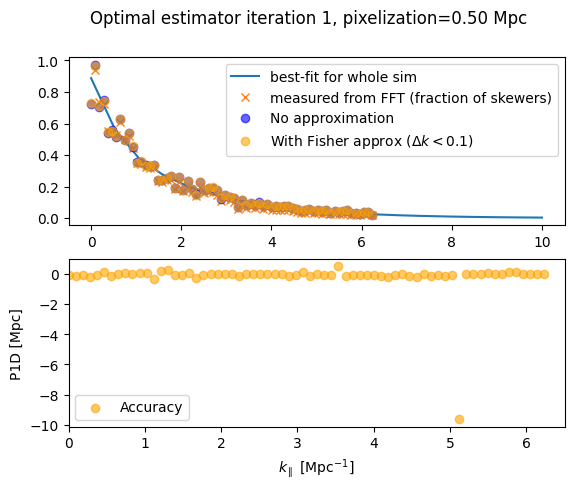

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(np.linspace(0, 10, 20), p1d, label='best-fit for whole sim')
ax[0].plot(kpar_b[1:], pk_avg[1:], marker = 'x', linestyle='none', label='measured from FFT (fraction of skewers)')

ax[0].plot(kbin_centers,p1d_fid_stdbins+theta_est, 'o', label=r'No approximation', color='blue', alpha=.6)
ax[0].plot(kbin_centers,(p1d_fid_stdbins+theta_est_apx), 'o', label=r'With Fisher approx ($\Delta k<0.1$)', color='orange', alpha=.6)
diff = (theta_est_apx-theta_est)/theta_est
# plot the differences
ax[1].scatter(kbin_centers,diff, label=r'Accuracy', color='orange', alpha=.6)
plt.xlim([0,6.5])
ax[0].legend()
ax[1].legend()
plt.suptitle("Optimal estimator iteration 1, pixelization={:.2f} Mpc".format(pix_spacing_b))
plt.ylabel("P1D [Mpc]")
plt.xlabel("$k_\parallel$ [Mpc$^{-1}$]")

Text(0, 0.5, 'Time for full estimate [sec]')

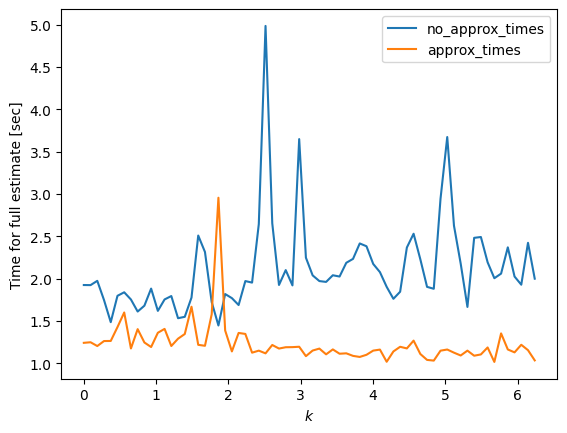

In [20]:
# plot the timings
plt.plot(kbin_centers, times, label="no_approx_times")
plt.plot(kbin_centers, times_apx, label="approx_times")
plt.legend()
plt.xlabel(r"$k$")
plt.ylabel("Time for full estimate [sec]")

In [21]:
F_inv = np.linalg.inv(F_alpha_beta)
F_inv_apx = np.linalg.inv(F_alpha_beta_apx)

Text(0.5, 0, '$k$ bin center')

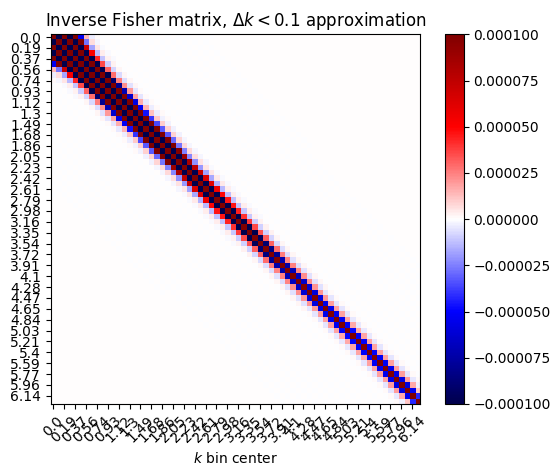

In [22]:
# repeat the plots for the inverse
plt.imshow(F_inv_apx, cmap='seismic', vmin=-.0001, vmax=.0001)
plt.colorbar()
plt.title(r"Inverse Fisher matrix, $\Delta k<0.1$ approximation")
plt.xticks(np.arange(0, len(kbin_centers_apx),2), np.round(kbin_centers_apx[::2], 2), rotation=45)
plt.yticks(np.arange(0, len(kbin_centers_apx),2), np.round(kbin_centers_apx[::2], 2))
plt.xlabel("$k$ bin center")


Text(0.5, 0, '$k$ bin center')

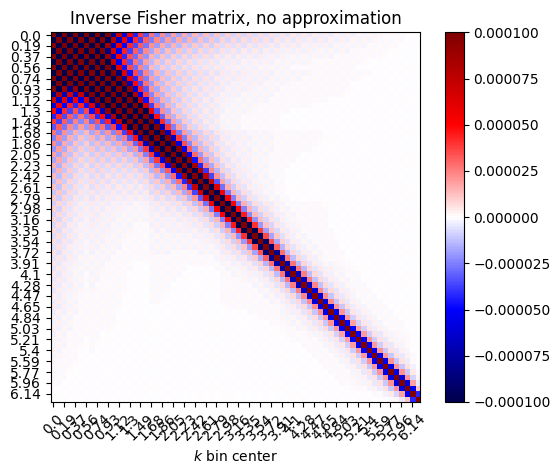

In [23]:
# repeat the plots for the inverse
plt.imshow(F_inv, cmap='seismic', vmin=-.0001, vmax=.0001)
plt.colorbar()
plt.title("Inverse Fisher matrix, no approximation")
plt.xticks(np.arange(0, len(kbin_centers),2), np.round(kbin_centers[::2], 2), rotation=45)
plt.yticks(np.arange(0, len(kbin_centers),2), np.round(kbin_centers[::2], 2))
plt.xlabel("$k$ bin center")
